# Proyecto Malaria Francisco

## Librerias

In [1]:
import kagglehub
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import shutil
import numpy as np
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import shutil

## Descargando los datos

In [2]:
# Fuente: https://www.kaggle.com/datasets/rajsahu2004/lacuna-malaria-detection-dataset

# Download latest version
path = kagglehub.dataset_download("rajsahu2004/lacuna-malaria-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.99G/3.99G [00:41<00:00, 102MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rajsahu2004/lacuna-malaria-detection-dataset/versions/1


In [4]:
!ls  /root/.cache/kagglehub/datasets/rajsahu2004/lacuna-malaria-detection-dataset/versions/1

images	SampleSubmission.csv  Test.csv	Train.csv


# Analisis Exploratorio de Datos

## Images

In [5]:
!ls  /root/.cache/kagglehub/datasets/rajsahu2004/lacuna-malaria-detection-dataset/versions/1/images


id_0051lznyrt.jpg  id_7jm7lmwa9o.jpg  id_edv38vgt8j.jpg  id_lyik8bvy4d.jpg  id_t3q5efe9zq.jpg
id_00m1onu6hj.jpg  id_7jre81rq19.jpg  id_eehci9jvxx.jpg  id_lymfimbfy7.jpg  id_t4a1u3o0u8.jpg
id_00n92f65ke.jpg  id_7jrwj14xhk.jpg  id_eeluv2nmp7.jpg  id_m0272ogw01.jpg  id_t4ahof8989.jpg
id_00sirs797x.jpg  id_7kty8z34mr.jpg  id_eerjo3sps4.jpg  id_m05pcdzm2h.jpg  id_t4b5gldbj4.jpg
id_013o32svbt.jpg  id_7l122v70fp.jpg  id_ef0jw5a0zi.jpg  id_m0kwdfv3n8.jpg  id_t4mlal96zd.jpg
id_021o79u9zs.jpg  id_7l5fy1nin2.jpg  id_ef4lnbhyxw.jpg  id_m1twcayvuf.jpg  id_t4y03l1pft.jpg
id_02i83lum2m.jpg  id_7lcplrs6uk.jpg  id_efep7fslyr.jpg  id_m2ibf6zkn9.jpg  id_t4zsobmg62.jpg
id_02kpdbnrfn.jpg  id_7lir0ghig8.jpg  id_eftvcf9djb.jpg  id_m2sb3vo43l.jpg  id_t57hhd5zxl.jpg
id_02q5ah1zvq.jpg  id_7lync2enge.jpg  id_egnmwq30pk.jpg  id_m33vrqvm4u.jpg  id_t5sklk78fx.jpg
id_03e6tz6thd.jpg  id_7lzf17si63.jpg  id_egu5f4y1bu.jpg  id_m3igovua55.jpg  id_t6lppa8k34.jpg
id_042y6d5xok.jpg  id_7m2e9q9vlh.jpg  id_egxyidlzzm.jpg  id_

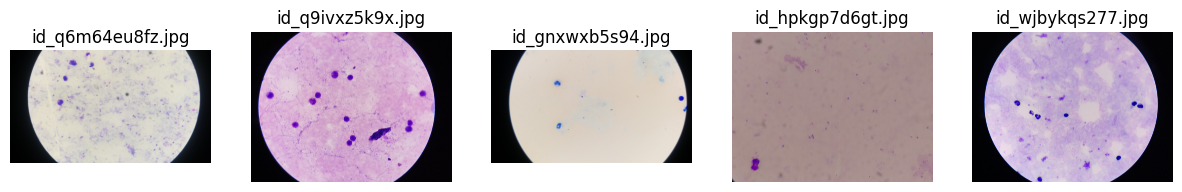

In [7]:
# prompt: Visualiza una muestra de las imagenes que se encuentren en !ls  /root/.cache/kagglehub/datasets/rajsahu2004/lacuna-malaria-detection-dataset/versions/1

# Path to the image directory
image_dir = path+'/images'

# Number of images to display
num_images_to_display = 5

# Get a list of image files in the directory
image_files = [f for f in np.random.choice(os.listdir(image_dir),num_images_to_display) if os.path.isfile(os.path.join(image_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Check if any images are found
if not image_files:
    print("No images found in the specified directory.")
else:
    # Display a sample of images
    fig, axes = plt.subplots(1, min(num_images_to_display, len(image_files)), figsize=(15, 5))
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_dir, image_file)
        try:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
            axes[i].imshow(img)
            axes[i].set_title(image_file)
            axes[i].axis('off')
        except Exception as e:
            print(f"Error displaying image {image_file}: {e}")
    plt.show()

## sample

In [8]:
df_sample_sub = pd.read_csv(path+'/SampleSubmission.csv')
df_sample_sub.head()

Image_ID        class  confidence  ymin  xmin  ymax  xmax
0  id_02i83lum2m.jpg          NEG         0.5   100   100   100   100
1  id_02i83lum2m.jpg  Trophozoite         0.5   100   100   100   100
2  id_02i83lum2m.jpg          WBC         0.5   100   100   100   100
3  id_02kpdbnrfn.jpg          NEG         0.5   100   100   100   100
4  id_02kpdbnrfn.jpg  Trophozoite         0.5   100   100   100   100

In [9]:
df_sample_sub.shape

(3534, 7)

In [10]:
df_sample_sub.isnull().sum()

Image_ID      0
class         0
confidence    0
ymin          0
xmin          0
ymax          0
xmax          0
dtype: int64

In [11]:
df_sample_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Image_ID    3534 non-null   object 
 1   class       3534 non-null   object 
 2   confidence  3534 non-null   float64
 3   ymin        3534 non-null   int64  
 4   xmin        3534 non-null   int64  
 5   ymax        3534 non-null   int64  
 6   xmax        3534 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 193.4+ KB


In [12]:
img_id = np.random.choice(df_sample_sub.Image_ID.unique())
df_sample_sub[df_sample_sub['Image_ID']==str(img_id)]

Image_ID        class  confidence  ymin  xmin  ymax  xmax
885  id_90g98gxi3p.jpg          NEG         0.5   100   100   100   100
886  id_90g98gxi3p.jpg  Trophozoite         0.5   100   100   100   100
887  id_90g98gxi3p.jpg          WBC         0.5   100   100   100   100

In [13]:
df_sample_sub.groupby('Image_ID').count()['class'].unique()

array([3])

## Test train

In [3]:
#Test.csv
df_test = pd.read_csv(path+'/Test.csv')
df_test.head()

Image_ID  class  confidence  ymin  xmin  ymax  xmax
0  id_5n9ov0rr22.jpg    NaN         NaN   NaN   NaN   NaN   NaN
1  id_k6s11k3klo.jpg    NaN         NaN   NaN   NaN   NaN   NaN
2  id_eftvcf9djb.jpg    NaN         NaN   NaN   NaN   NaN   NaN
3  id_kc5tmoj1xa.jpg    NaN         NaN   NaN   NaN   NaN   NaN
4  id_tirid4qt68.jpg    NaN         NaN   NaN   NaN   NaN   NaN

In [15]:
df_test.shape

(1178, 7)

In [16]:
df_test.isnull().sum()

Image_ID         0
class         1178
confidence    1178
ymin          1178
xmin          1178
ymax          1178
xmax          1178
dtype: int64

In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178 entries, 0 to 1177
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Image_ID    1178 non-null   object 
 1   class       0 non-null      float64
 2   confidence  0 non-null      float64
 3   ymin        0 non-null      float64
 4   xmin        0 non-null      float64
 5   ymax        0 non-null      float64
 6   xmax        0 non-null      float64
dtypes: float64(6), object(1)
memory usage: 64.5+ KB


In [4]:
df_train = pd.read_csv(path+'/Train.csv')
df_train.head()

Image_ID        class  confidence  ymin  xmin  ymax  xmax
0  id_u3q6jdck4j.jpg  Trophozoite         1.0   712  1241   737  1270
1  id_a6cl90trri.jpg  Trophozoite         1.0   558  1566   600  1604
2  id_qvc2le9sm8.jpg  Trophozoite         1.0  1317  2788  1448  2914
3  id_w8xnbd5rvm.jpg  Trophozoite         1.0   925  1744  1041  1823
4  id_6dop09rk02.jpg          NEG         1.0     0     0     0     0

In [18]:
df_train.shape

(23530, 7)

In [20]:
df_train.isnull().sum()

Image_ID      0
class         0
confidence    0
ymin          0
xmin          0
ymax          0
xmax          0
dtype: int64

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23530 entries, 0 to 23529
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Image_ID    23530 non-null  object 
 1   class       23530 non-null  object 
 2   confidence  23530 non-null  float64
 3   ymin        23530 non-null  int64  
 4   xmin        23530 non-null  int64  
 5   ymax        23530 non-null  int64  
 6   xmax        23530 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 1.3+ MB


In [22]:
df_train.groupby('Image_ID').count()['class'].unique()

array([ 4,  1,  8, 16,  5, 10,  3,  2, 33, 15, 21, 35, 13, 14,  9, 12,  6,
       22,  7, 18, 29, 70, 11, 19, 24, 47, 51, 20, 74, 26, 49, 41, 31, 60,
       43, 54, 17, 25, 45, 44, 38, 23, 63, 50, 46, 40, 34, 37, 36, 28, 32,
       30, 27, 72, 62, 55, 64, 39, 42, 92, 73, 56, 58, 85, 66, 68, 52, 48,
       53])

In [23]:
img_id = np.random.choice(df_train.Image_ID.unique())
df_train[df_train['Image_ID']==str(img_id)]

Image_ID        class  confidence  ymin  xmin  ymax  xmax
1328   id_ue5wezctio.jpg  Trophozoite         1.0   787   431   819   467
1971   id_ue5wezctio.jpg  Trophozoite         1.0   770  1394   798  1426
2742   id_ue5wezctio.jpg  Trophozoite         1.0   874   564   900   590
5024   id_ue5wezctio.jpg          WBC         1.0   624   832   686   889
8360   id_ue5wezctio.jpg  Trophozoite         1.0   414  1685   448  1719
10491  id_ue5wezctio.jpg  Trophozoite         1.0   253  1388   283  1414
12144  id_ue5wezctio.jpg          WBC         1.0    38   810    87   876
12637  id_ue5wezctio.jpg  Trophozoite         1.0   689   543   733   581
13500  id_ue5wezctio.jpg  Trophozoite         1.0   815   524   845   554
13654  id_ue5wezctio.jpg          WBC         1.0  1025   689  1078   755
15334  id_ue5wezctio.jpg  Trophozoite         1.0   783   653   823   691
16107  id_ue5wezctio.jpg  Trophozoite         1.0   853   253   891   289
21499  id_ue5wezctio.jpg  Trophozoite         1.0   929   409   967   437
23503  id_ue5wezctio.jpg  Trophozoite         1.0   912   333   940   359

In [24]:
df_train['class'].unique() # WBC se refiere a un globulo blanco

array(['Trophozoite', 'NEG', 'WBC'], dtype=object)

## Entendiendo datos en las imagenes

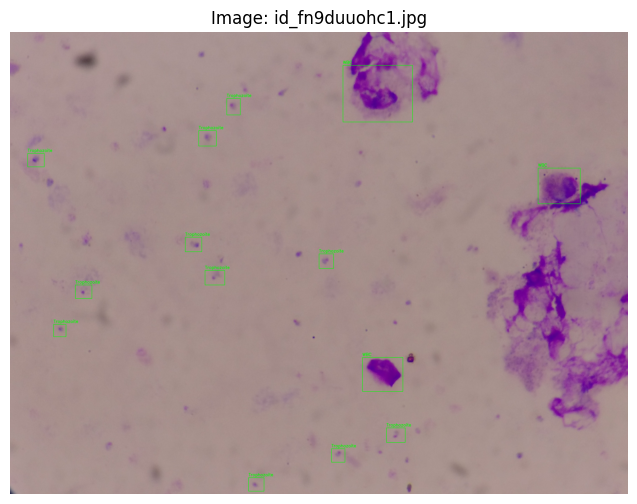

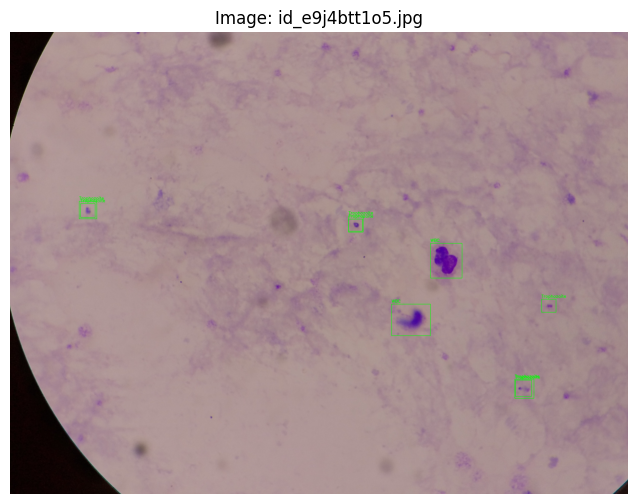

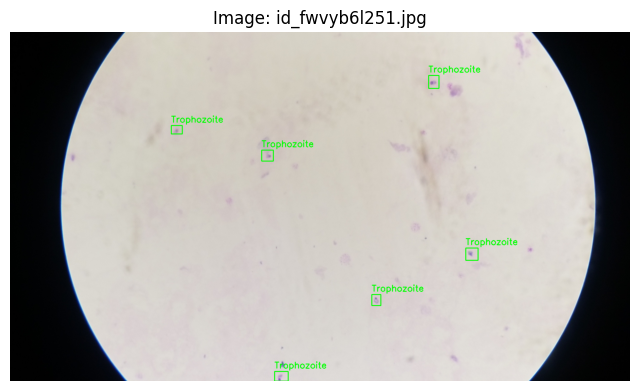

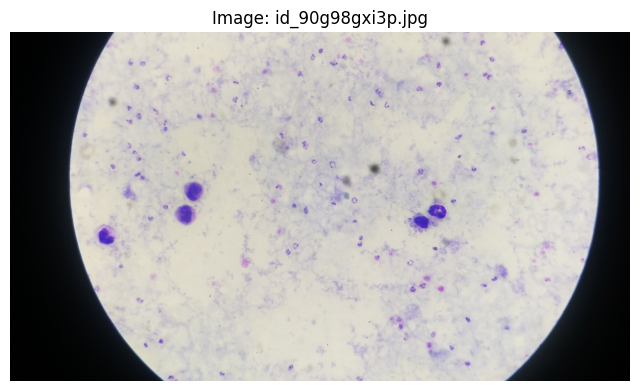

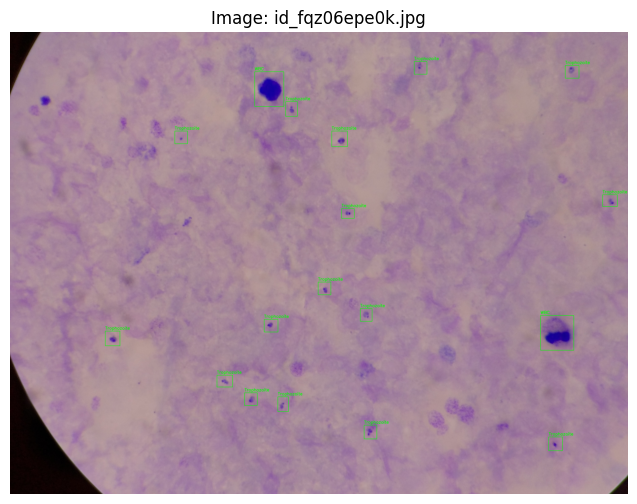

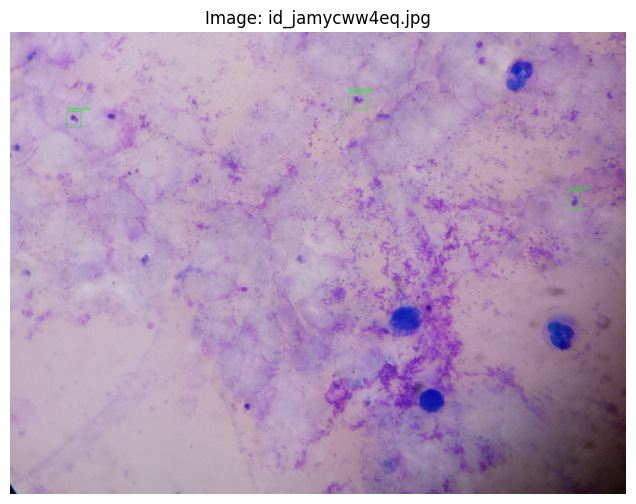

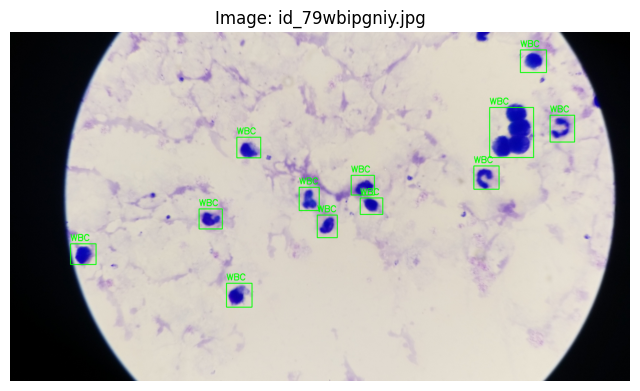

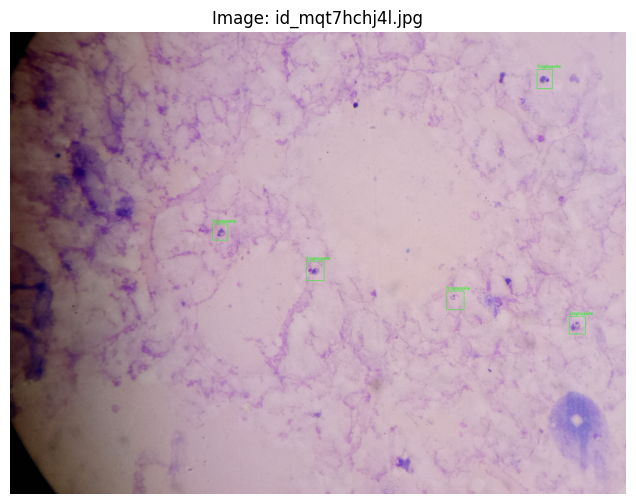

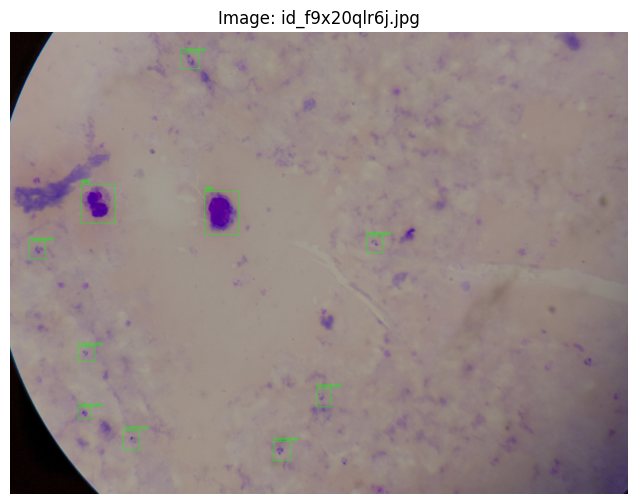

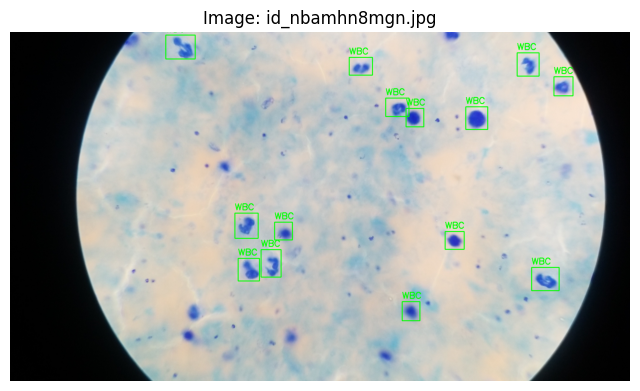

In [25]:
# prompt: de la celda entarior por cada cajita coloca la classee


# Assuming df_train contains 'Image_ID', 'xmin', 'ymin', 'xmax', 'ymax' columns
# and the image directory is '/root/.cache/kagglehub/datasets/rajsahu2004/lacuna-malaria-detection-dataset/versions/1/train'

# Path to the image directory
image_dir = path+'/images'

# Number of images to display
num_images_to_display = 10

for image_file in np.random.choice(os.listdir(image_dir),num_images_to_display):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(image_dir, image_file)
        image_id = image_file  # Assuming the filename is the Image_ID

        try:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Filter the dataframe to get bounding box info for this image
            image_data = df_train[df_train['Image_ID'] == image_id]

            for index, row in image_data.iterrows():
                xmin = int(row['xmin'])
                ymin = int(row['ymin'])
                xmax = int(row['xmax'])
                ymax = int(row['ymax'])
                class_name = row['class'] # Get the class label

                # Draw bounding box on the image
                cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

                # Add class label text
                cv2.putText(img, class_name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)


            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.title(f"Image: {image_id}")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error processing image {image_file}: {e}")

In [26]:
df_train[df_train['Image_ID'] == 'id_90g98gxi3p.jpg'] # La imagen id_90g98gxi3p.jpg no esta en df_train solo en text

Empty DataFrame
Columns: [Image_ID, class, confidence, ymin, xmin, ymax, xmax]
Index: []

In [37]:
set(df_train.Image_ID.unique()).intersection(set(df_sample_sub.Image_ID.unique()))

set()

In [38]:
len(set(df_test.Image_ID.unique()).intersection(set(df_sample_sub.Image_ID.unique())))

1178

In [39]:
set(df_test.Image_ID.unique()).intersection(set(df_train.Image_ID.unique()))

set()

In [28]:
id_test = df_test.Image_ID.unique()
id_train = df_train.Image_ID.unique()
print(len(id_test),len(id_train),len(id_test)+len(id_train)) #There are 2 747 images in the train and 1 178 in the test.

1178 2747 3925


In [29]:
# prompt: crea una data frame con ancho alruta y numero de calanes de las imagenes que vienen en la carpeta

# Path to the image directory
image_dir = path+'/images'

image_data = []
for filename in os.listdir(image_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        filepath = os.path.join(image_dir, filename)
        try:
            img = cv2.imread(filepath)
            if img is not None:  # Check if the image was loaded successfully
                height, width, num_canales = img.shape
                image_data.append([filename, width, height, num_canales])
            else:
                print(f"Error: Could not read image file {filepath}")
        except Exception as e:
            print(f"Error processing image {filename}: {e}")

df = pd.DataFrame(image_data, columns=['filename', 'width', 'height', 'num_calanes'])
print(df.head())

            filename  width  height  num_calanes
0  id_7obw19n3a4.jpg   4032    3016            3
1  id_q7akj9v4f3.jpg   1920    1080            3
2  id_3pdu483z6w.jpg   4000    3000            3
3  id_vh0k3szcjh.jpg   1920    1080            3
4  id_k061rd9uty.jpg   1920    1080            3


In [30]:
df.describe()

width       height  num_calanes
count  3925.000000  3925.000000       3925.0
mean   3303.794140  2350.159490          3.0
std    1013.374169   929.853936          0.0
min    1920.000000  1080.000000          3.0
25%    1920.000000  1080.000000          3.0
50%    4000.000000  3000.000000          3.0
75%    4032.000000  3016.000000          3.0
max    4160.000000  3120.000000          3.0

# Creando el conjunto de datos para el entrenamiento
con base en:

https://www.kaggle.com/code/swarnabh31/computervision-end-to-end-transferlearning

y reduciendo el deafio a un problema de clasificacion

Revisar https://en.wikipedia.org/wiki/Trophozoite

In [5]:
df_train['Malaria'] = df_train['class'].apply(lambda x: 'Malaria_SI' if x in ['Trophozoite', 'WBC'] else 'Malaria_NO')

In [32]:
df_train[df_train['Malaria']=='Malaria_SI'].Image_ID.value_counts()

Image_ID
id_mzq1jmom69.jpg    92
id_tmtzoe9bns.jpg    85
id_7tgo99b7gy.jpg    74
id_1xpbtfb4xh.jpg    74
id_n5talfnmmk.jpg    73
                     ..
id_v6ovpv2ltd.jpg     1
id_j2qlimwxp5.jpg     1
id_kei6f1kb78.jpg     1
id_ornzwhm7q0.jpg     1
id_8qftjzdycu.jpg     1
Name: count, Length: 2059, dtype: int64

In [33]:
df_train[df_train.Image_ID == 'id_8qftjzdycu.jpg']

Image_ID        class  confidence  ymin  xmin  ymax  xmax  \
23495  id_8qftjzdycu.jpg  Trophozoite         1.0   722  2815   859  2963   

          Malaria  
23495  Malaria_SI

In [34]:
df_train[df_train['class'].isin(['WBC','Trophozoite'])].describe()

confidence          ymin          xmin          ymax          xmax
count     22842.0  22842.000000  22842.000000  22842.000000  22842.000000
mean          1.0    826.975177   1331.269066    904.708257   1407.974433
std           0.0    671.525655    843.460252    698.474810    866.961141
min           1.0      0.000000      0.000000     22.000000     98.000000
25%           1.0    342.000000    723.000000    399.000000    780.250000
50%           1.0    637.000000   1133.000000    698.000000   1194.000000
75%           1.0   1036.750000   1646.000000   1157.000000   1725.000000
max           1.0   3012.000000   4051.000000   3116.000000   4155.000000

In [35]:
df_train[df_train['class']=='NEG'].describe()

confidence   ymin   xmin   ymax   xmax
count       688.0  688.0  688.0  688.0  688.0
mean          1.0    0.0    0.0    0.0    0.0
std           0.0    0.0    0.0    0.0    0.0
min           1.0    0.0    0.0    0.0    0.0
25%           1.0    0.0    0.0    0.0    0.0
50%           1.0    0.0    0.0    0.0    0.0
75%           1.0    0.0    0.0    0.0    0.0
max           1.0    0.0    0.0    0.0    0.0

In [36]:
df_train[df_train['class']=='NEG'].head(3)

Image_ID class  confidence  ymin  xmin  ymax  xmax     Malaria
4   id_6dop09rk02.jpg   NEG         1.0     0     0     0     0  Malaria_NO
8   id_y0me081u0v.jpg   NEG         1.0     0     0     0     0  Malaria_NO
63  id_2pye2ftpl6.jpg   NEG         1.0     0     0     0     0  Malaria_NO

<Axes: xlabel='class', ylabel='count'>

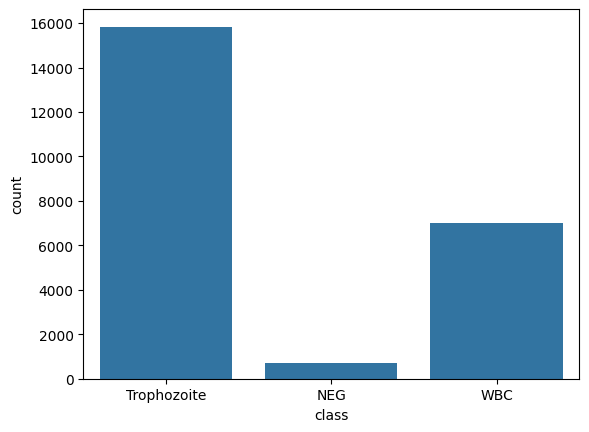

In [40]:

sns.countplot(df_train, x="class")

In [41]:
df_train[df_train['Malaria']=='Malaria_SI'].Image_ID.nunique() # Perdimos las imagenes que solo tienen etiquete WBC

2059

In [42]:
df_train[df_train['Malaria']=='Malaria_NO'].Image_ID.nunique()

688

In [43]:
2059+688

2747



```
# This is formatted as code
```

# Entrenar modelo

In [8]:
# Create image paths for training data
df_train['image_path'] = df_train['Image_ID'].apply(lambda x: os.path.join(image_dir, x))
df_train.head()

Image_ID        class  confidence  ymin  xmin  ymax  xmax  \
0  id_u3q6jdck4j.jpg  Trophozoite         1.0   712  1241   737  1270   
1  id_a6cl90trri.jpg  Trophozoite         1.0   558  1566   600  1604   
2  id_qvc2le9sm8.jpg  Trophozoite         1.0  1317  2788  1448  2914   
3  id_w8xnbd5rvm.jpg  Trophozoite         1.0   925  1744  1041  1823   
4  id_6dop09rk02.jpg          NEG         1.0     0     0     0     0   

      Malaria                                         image_path  
0  Malaria_SI  /root/.cache/kagglehub/datasets/rajsahu2004/la...  
1  Malaria_SI  /root/.cache/kagglehub/datasets/rajsahu2004/la...  
2  Malaria_SI  /root/.cache/kagglehub/datasets/rajsahu2004/la...  
3  Malaria_SI  /root/.cache/kagglehub/datasets/rajsahu2004/la...  
4  Malaria_NO  /root/.cache/kagglehub/datasets/rajsahu2004/la...

In [46]:
df_train.image_path.iloc[0]

'/root/.cache/kagglehub/datasets/rajsahu2004/lacuna-malaria-detection-dataset/versions/1/images/id_u3q6jdck4j.jpg'

In [9]:
# Split training data into train and validation sets
train_data, val_data = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['Malaria'])

In [10]:
# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalization
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

# Only rescaling for validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='Malaria',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle= True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='Malaria',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False
)

# Prepare test data
df_test['image_path'] = df_test['Image_ID'].apply(lambda x: os.path.join(image_dir, x))
test_generator = val_test_datagen.flow_from_dataframe(
    df_test,
    x_col='image_path',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 18824 validated image filenames belonging to 2 classes.
Found 4706 validated image filenames belonging to 2 classes.
Found 1178 validated image filenames.


In [11]:
# Print some information about the data
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Number of training samples: {len(train_generator)}")
print(f"Number of validation samples: {len(val_generator)}")
print(f"Number of test samples: {len(test_generator)}")

# Check class balance
print("\nClass distribution in training data:")
print(train_data['Malaria'].value_counts(normalize=True))
print("\nClass distribution in validation data:")
print(val_data['Malaria'].value_counts(normalize=True))

Number of classes: 2
Number of training samples: 589
Number of validation samples: 148
Number of test samples: 37

Class distribution in training data:
Malaria
Malaria_SI    0.970782
Malaria_NO    0.029218
Name: proportion, dtype: float64

Class distribution in validation data:
Malaria
Malaria_SI    0.970676
Malaria_NO    0.029324
Name: proportion, dtype: float64


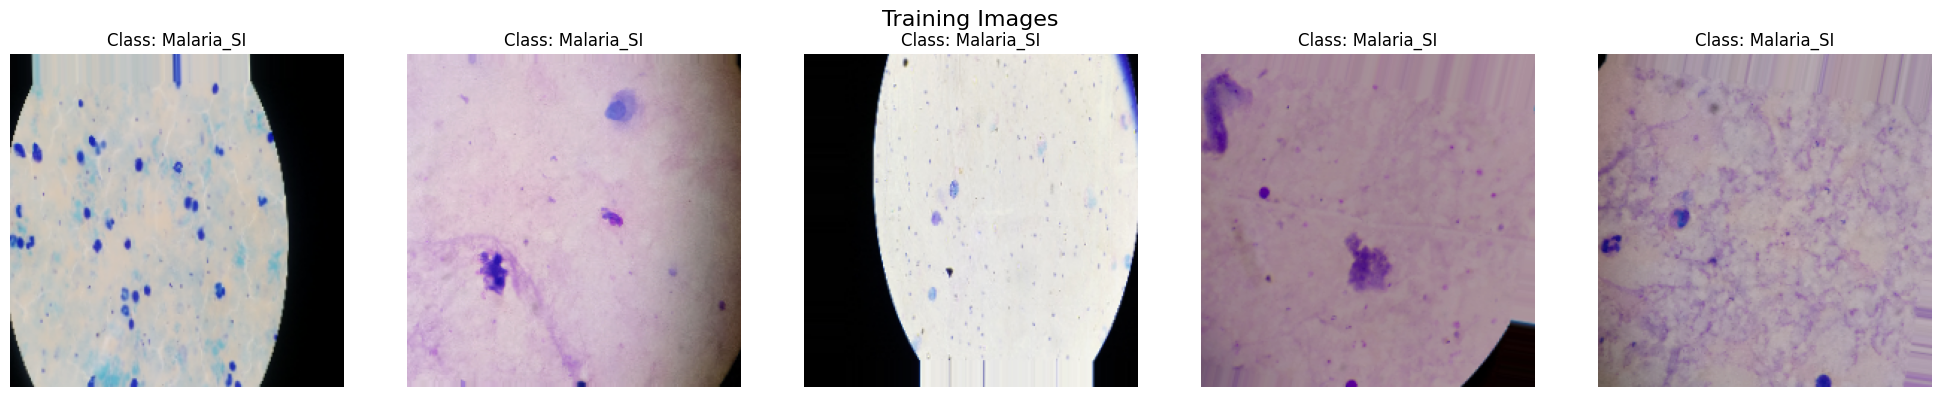

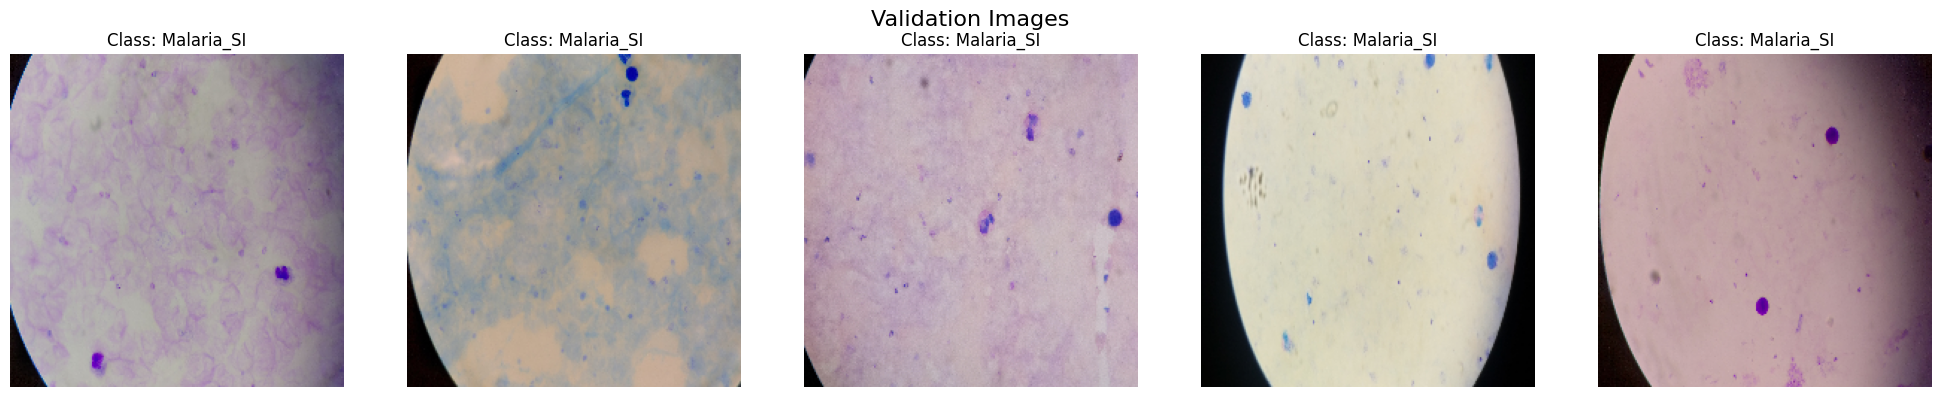

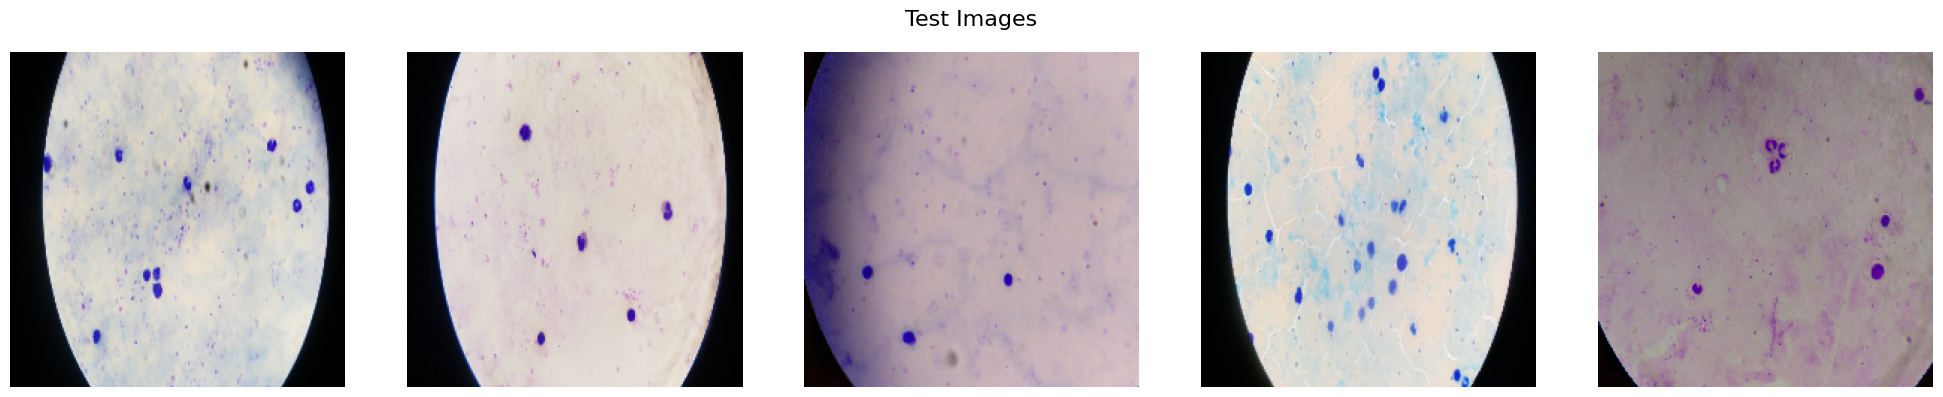

In [52]:
def plot_images(generator, title, n=5):
    plt.figure(figsize=(20, 4))
    plt.suptitle(title, fontsize=16)

    # Check if the generator has class information
    has_classes = hasattr(generator, 'class_indices')

    if has_classes:
        # Get the class indices
        class_indices = generator.class_indices
        # Invert the dictionary to map indices to class names
        index_to_class = {v: k for k, v in class_indices.items()}

    for i in range(n):
        # Get a batch of images
        batch = next(generator)

        # For train and validation, batch is a tuple (images, labels)
        # For test, batch is just images
        if isinstance(batch, tuple):
            images, labels = batch
        else:
            images = batch

        # Select a random image from the batch
        idx = np.random.randint(0, images.shape[0])
        img = images[idx]

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')

        if has_classes and isinstance(batch, tuple):
            label_idx = np.argmax(labels[idx])
            class_name = index_to_class[label_idx]
            plt.title(f"Class: {class_name}")

    plt.tight_layout()
    plt.show()

# Visualize training images
plot_images(train_generator, "Training Images")

# Visualize validation images
plot_images(val_generator, "Validation Images")

# Visualize test images
plot_images(test_generator, "Test Images")


In [12]:
# Define the model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
steps_per_epoch = len(train_data) // batch_size

In [14]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
])

In [15]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['recall'])

In [16]:
# Train the model with frozen base
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_frozen = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=None,
    callbacks=[early_stopping],
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


588/588 ━━━━━━━━━━━━━━━━━━━━ 1140s 2s/step - loss: 0.1560 - recall: 0.9593 - val_loss: 0.1324 - val_recall: 0.9707
Epoch 2/10
  1/588 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - loss: 0.1406 - recall: 0.9688

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


588/588 ━━━━━━━━━━━━━━━━━━━━ 172s 294ms/step - loss: 0.1406 - recall: 0.9688 - val_loss: 0.1324 - val_recall: 0.9707
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 1049s 2s/step - loss: 0.1373 - recall: 0.9697 - val_loss: 0.1324 - val_recall: 0.9707
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 162s 275ms/step - loss: 0.1347 - recall: 0.9688 - val_loss: 0.1325 - val_recall: 0.9707


In [17]:
# Unfreeze some layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [18]:
# Recompile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['recall'])

# Train the model with unfrozen layers
history_unfrozen = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=None,
    callbacks=[early_stopping]
)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 1110s 2s/step - loss: 0.1800 - recall: 0.9571 - val_loss: 0.1322 - val_recall: 0.9707
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 172s 293ms/step - loss: 0.0390 - recall: 1.0000 - val_loss: 0.1323 - val_recall: 0.9707
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 1032s 2s/step - loss: 0.1368 - recall: 0.9699 - val_loss: 0.1340 - val_recall: 0.9707
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 170s 290ms/step - loss: 0.1503 - recall: 0.9688 - val_loss: 0.1343 - val_recall: 0.9707


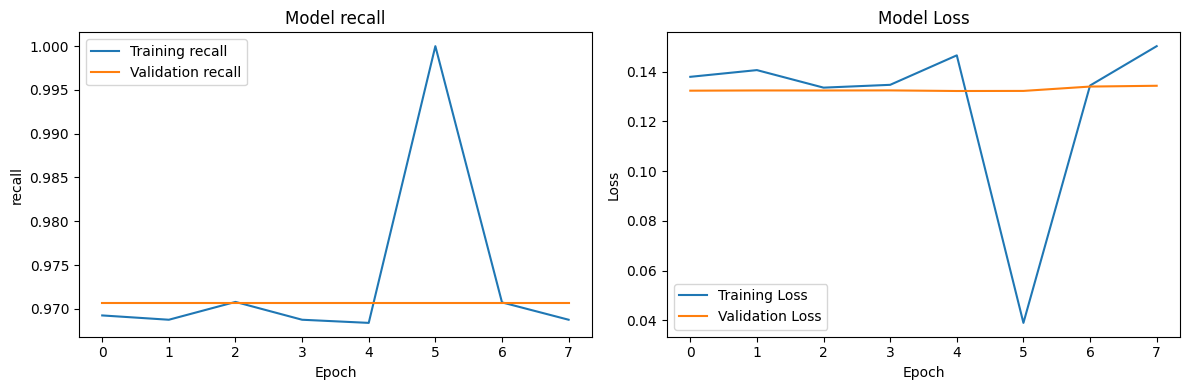

In [20]:
# Combine histories
history = {}
history['recall'] = history_frozen.history['recall']  + history_unfrozen.history['recall']
history['val_recall'] = history_frozen.history['val_recall'] + history_unfrozen.history['val_recall']
history['loss'] = history_frozen.history['loss'] + history_unfrozen.history['loss']
history['val_loss'] = history_frozen.history['val_loss'] + history_unfrozen.history['val_loss']

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['recall'], label='Training recall')
plt.plot(history['val_recall'], label='Validation recall')
plt.title('Model recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Evaluate the model
test_loss, test_recall = model.evaluate(val_generator)
print(f"Test recall: {test_recall:.4f}")

148/148 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - loss: 0.1204 - recall: 0.9740
Test recall: 0.9707


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


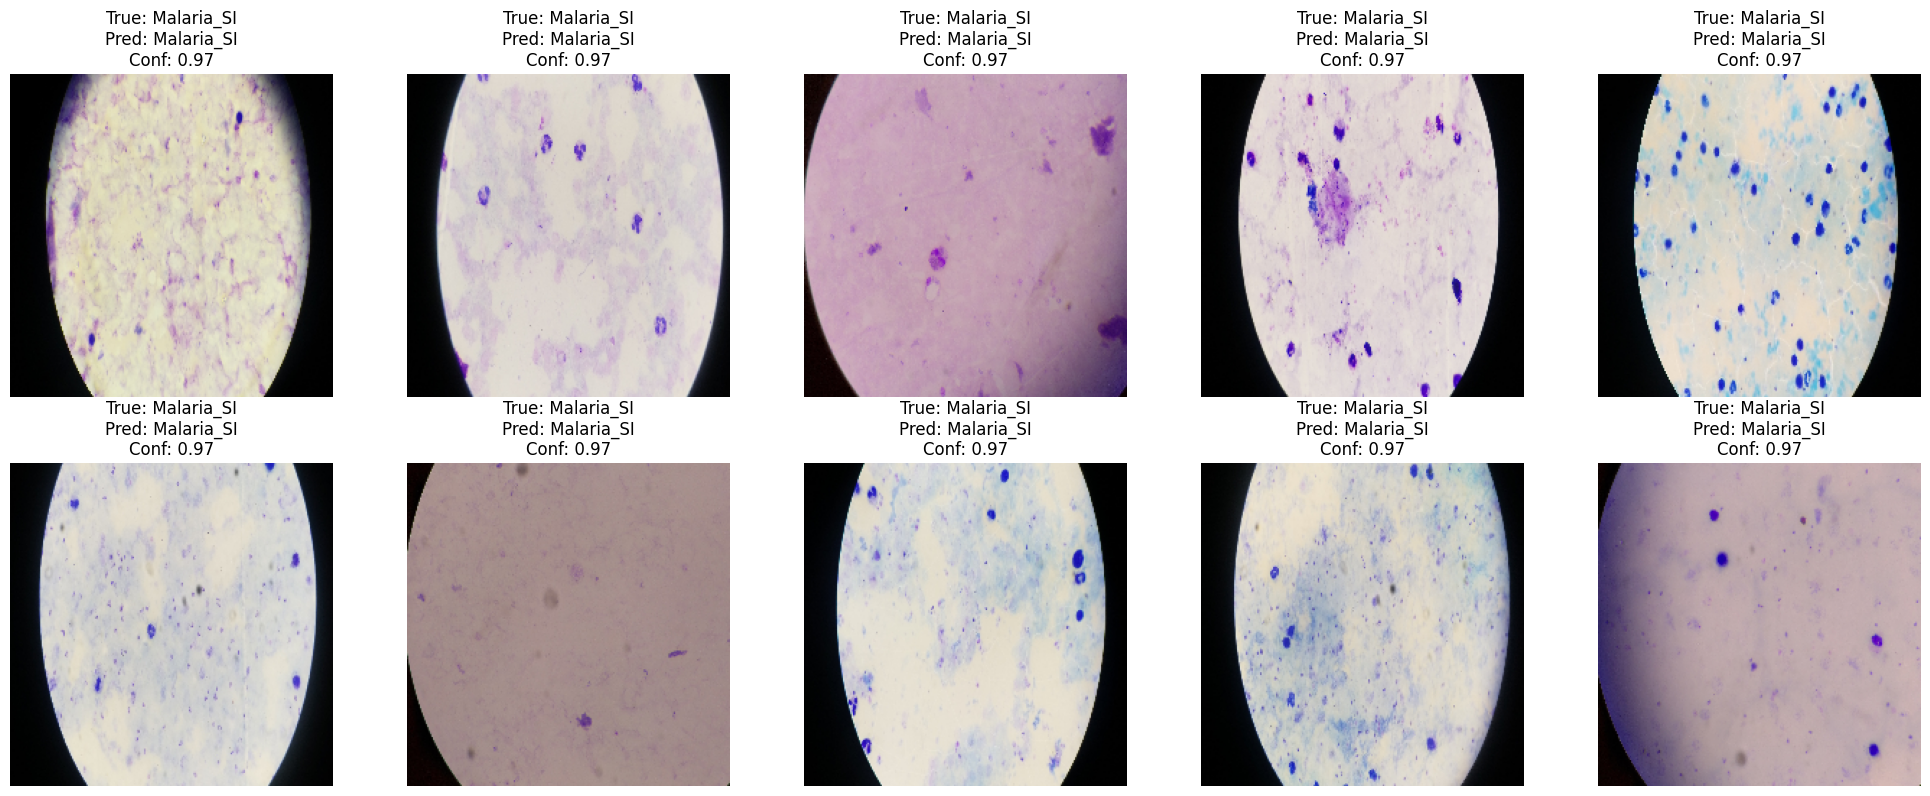

In [22]:

def plot_sample_predictions(model, val_generator, val_data, num_samples=10):
    # Get a batch of validation data
    batch_x, batch_y = next(val_generator)

    # Get predictions
    predictions = model.predict(batch_x)

    # Get class labels
    class_labels = list(val_generator.class_indices.keys())

    # Randomly select samples
    indices = random.sample(range(len(batch_x)), num_samples)

    # Plot the samples
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        # Get the image and its true label
        img = batch_x[idx]
        true_label = class_labels[np.argmax(batch_y[idx])]

        # Get the predicted label and confidence
        pred_label = class_labels[np.argmax(predictions[idx])]
        confidence = np.max(predictions[idx])

        # Plot the image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}")

    plt.tight_layout()
    plt.show()

# Use the function
plot_sample_predictions(model, val_generator, val_data)

In [23]:
# prompt: Cuarga el modelo entrenado para ser utilizado en un dokerfile

# Save the model in SavedModel format
model.save('malaria_detection_model.h5')

# The following commands would be in your Dockerfile

# Install necessary libraries
# RUN pip install tensorflow

# Copy the model files
# COPY malaria_detection_model /app/malaria_detection_model

# Set the working directory
# WORKDIR /app

# Example inference code (you can place this in your app)
# loaded_model = tf.keras.models.load_model('malaria_detection_model')
# # ... use the loaded model to make predictions

In [24]:
model.save('malaria_detection_model.keras')

#Predictions on Test Data¶


In [27]:
# Get predictions
predictions = model.predict(test_generator, steps=len(df_test) // batch_size + 1)

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Create a DataFrame with predictions
df_results = pd.DataFrame({
    'Image_ID': df_test['Image_ID'],
    'Predicted_Class': [class_labels[np.argmax(pred)] for pred in predictions],
    'Confidence': [np.max(pred) for pred in predictions]
})

37/37 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step


In [29]:
df_results.head()

Image_ID Predicted_Class  Confidence
0  id_5n9ov0rr22.jpg      Malaria_SI    0.972387
1  id_k6s11k3klo.jpg      Malaria_SI    0.972417
2  id_eftvcf9djb.jpg      Malaria_SI    0.972385
3  id_kc5tmoj1xa.jpg      Malaria_SI    0.972365
4  id_tirid4qt68.jpg      Malaria_SI    0.972106

In [30]:
df_results.Predicted_Class.unique()

array(['Malaria_SI'], dtype=object)

In [31]:
import sys
with open("version_python.txt", "w") as file:
    file.write(f"Python version: {sys.version}\n")


In [32]:
!pip freeze > requerimientos.txt


In [34]:
from google.colab import files

# Descargar las versiones de Python y dependencias
files.download("version_python.txt")
files.download("requerimientos.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>